In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 9.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import  seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from itertools import  combinations
turkish_trans_table = str.maketrans(
    "İIıÖöÜüÇçŞşĞğÜü",
    "iiioouuccssgguu")

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,KFold
import optuna
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,KFold,TimeSeriesSplit
import warnings

pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=50

from tqdm import tqdm,tqdm_notebook
tqdm.pandas(desc='my bar')

import warnings
warnings.filterwarnings('ignore')

/usr/local/python/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cat_analyser(data, col, freq_limit = 100):
    color = '#ff661f'
    cmap1 = 'Oranges'
    cmap2 =  'Set3'
    palette1 = 'Oranges'
    palette2 = 'Set3'
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if df_[col].nunique() > freq_limit:
        df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                    keys()[:freq_limit].tolist())]
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    fig.suptitle(col, fontsize = 16)
    sns.countplot(data = df_,
                  x = col,
                  ax = ax[0],
                  palette= palette1,
                  order =  df_[col].value_counts().index)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 90)
    ax[0].set_xlabel('')
    
    
    pie_cmap = plt.get_cmap(cmap1)
    normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
    data[col].value_counts().plot.pie(autopct = '%1.1f%%',
                                      textprops = {'fontsize': 12},
                                      ax = ax[1],rotatelabels=True,
                                      colors = pie_cmap(normalize(df_[col].value_counts())))
    ax[1].set_ylabel('')
    plt.show()
#     plt.rc_file_defaults()
    sns.reset_orig()

In [3]:
df_weather=pd.read_csv('df_weather.csv')
df_weather.date_time=pd.to_datetime(df_weather.date_time)
df_weather.location=df_weather.location.str.translate(turkish_trans_table).str.lower()  
df_weather=df_weather.rename(columns={'date_time':'Tarih','location':'ilce'})
df_weather=df_weather[['Tarih', 'totalSnow_cm',
        'DewPointC', 'WindChillC',
       'WindGustKmph', 'pressure',
       'tempC', 'windspeedKmph', 'ilce']]
df_sehzadeler=df_weather[df_weather.ilce=='turgutlu']
df_sehzadeler.ilce='sehzadeler'
df_weather=pd.concat([df_weather,df_sehzadeler],axis=0).reset_index(drop=True)

In [4]:
df_weather

,Tarih,totalSnow_cm,DewPointC,WindChillC,WindGustKmph,pressure,tempC,windspeedKmph,ilce
0,2021-01-01 00:00:00,0.0,9.0,10.0,10.0,1016.0,11.0,6.0,saruhanli
1,2021-01-01 01:00:00,0.0,9.0,10.0,10.0,1016.0,10.0,6.0,saruhanli
2,2021-01-01 02:00:00,0.0,9.0,10.0,10.0,1016.0,10.0,6.0,saruhanli
3,2021-01-01 03:00:00,0.0,9.0,10.0,9.0,1016.0,10.0,5.0,saruhanli
4,2021-01-01 04:00:00,0.0,9.0,10.0,9.0,1016.0,10.0,5.0,saruhanli
...,...,...,...,...,...,...,...,...,...
151742,2022-08-10 19:00:00,0.0,16.0,23.0,28.0,1006.0,23.0,15.0,sehzadeler
151743,2022-08-10 20:00:00,0.0,16.0,22.0,17.0,1007.0,22.0,9.0,sehzadeler
151744,2022-08-10 21:00:00,0.0,16.0,21.0,6.0,1007.0,21.0,3.0,sehzadeler
151745,2022-08-10 22:00:00,0.0,14.0,21.0,7.0,1007.0,21.0,3.0,sehzadeler


In [5]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [6]:
#getting population data( taken from Tarık Karakaş )
from unidecode import unidecode
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'ilce','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'ilce','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['ilce']=ilce_nufus['ilce'].apply(unidecode).str.lower()
ilce_nufus.ilce_nufus=ilce_nufus.ilce_nufus.astype(float)*1000

# Train and Test set basic preprocessing

In [9]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.columns=train.columns.str.translate(turkish_trans_table).str.lower()  
train=train.apply(lambda x : x.str.translate(turkish_trans_table).str.lower() if x.dtype==object else x)
train.baslama_tarihi_ve_zamani=pd.to_datetime(train.baslama_tarihi_ve_zamani,dayfirst=True)
train.sona_erme_tarihi_ve_zamani=pd.to_datetime(train.sona_erme_tarihi_ve_zamani,dayfirst=True)
train['Tarih']=train.baslama_tarihi_ve_zamani.map(lambda  x : x.strftime('%Y-%m-%d %H:00:00'))
train.Tarih=pd.to_datetime(train.Tarih)
train=train.merge(ilce_nufus,how='left',on='ilce')
train['il_ilce']=train.il+'_'+train.ilce
train.drop(['kod_no','kademe', 'outageid','sebeke_unsuru_kodu','bildirime_gore'],axis=1,inplace=True)
lbls=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450','450-500', '500-550']
train['nufus_label']=pd.cut(train.ilce_nufus,bins=list(range(0,600000,50000)), labels=lbls,ordered=False,right=False) 

train=train[train.Tarih<'2022-03-24 00:00:00']
train.drop(['kirsal_og', 'kirsal_ag', 'kentalti_og',
       'toplam_kentalti_og', 'kentalti_ag'],axis=1,inplace=True)
train=pd.concat([train[train.cagri_count<1].sample(10000,replace=True),train[train.cagri_count>1]])

obj_cols=[col for  col in train.columns if train[col].dtype==object]
time_cols=['Tarih','baslama_tarihi_ve_zamani','sona_erme_tarihi_ve_zamani']
num_cols=[col for col in train.columns if train[col].dtype in ['float','int']]
display(train[obj_cols].describe())
display(train.describe())

,il,ilce,sebeke_unsuru,kesinti_nedenine_iliskin_aciklama,kaynaga_gore,sureye_gore,sebebe_gore,il_ilce
count,19433,19433,19433,19433,19433,19433,19433,19433
unique,2,47,8,57,3,2,3,47
top,izmir,cesme,abone tesisi,og fider acmasi,dagitim-ag,uzun,sebeke isletmecisi,izmir_cesme
freq,13901,1166,5306,4581,12696,18012,19047,1166


,kesinti_no,kesinti_suresi,kentsel_og,kentsel_ag,toplam_kentsel_og,toplam_kentsel_ag,toplam_kentalti_ag,toplam_kirsal_og,toplam_kirsal_ag,cagri_count,ilce_nufus
count,1.943300e+04,19433.000000,19433.000000,19433.000000,19433.000000,19433.000000,19433.000000,19433.000000,19433.000000,19433.000000,19433.000000
mean,2.239051e+06,1.953230,10.991303,464.394072,6.636127,277.381942,33.591173,2.191784,43.226168,8.763032,161673.754335
std,1.735082e+04,2.584922,44.746254,2172.379841,42.594707,1340.002076,276.744115,17.998676,302.941601,43.048841,133849.306481
min,2.212594e+06,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11927.000000
25%,2.224024e+06,0.634444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48167.000000
50%,2.234572e+06,1.371111,0.000000,8.000000,0.000000,10.071667,0.000000,0.000000,0.000000,0.000000,112049.000000
75%,2.255887e+06,2.555278,1.000000,128.000000,0.506667,124.523888,0.000000,0.000000,0.000000,5.000000,201476.000000
max,2.275874e+06,80.867500,903.000000,70961.000000,1691.530000,45208.908331,12326.607772,714.951111,14919.018885,2223.000000,517963.000000


In [93]:
test.columns=test.columns.str.translate(turkish_trans_table).str.lower()
test=test.apply(lambda x : x.str.translate(turkish_trans_table).str.lower() if x.dtype==object else x)
test.baslama_tarihi_ve_zamani=pd.to_datetime(test.baslama_tarihi_ve_zamani,dayfirst=True)
test.sona_erme_tarihi_ve_zamani=pd.to_datetime(test.sona_erme_tarihi_ve_zamani,dayfirst=True)
test['Tarih']=test.baslama_tarihi_ve_zamani.map(lambda  x : x.strftime('%Y-%m-%d %H:00:00'))
test.Tarih=pd.to_datetime(test.Tarih)
test['il_ilce']=test.il+'_'+test.ilce
test=test.merge(ilce_nufus,how='left',on='ilce')
test.drop(['kademe', 'outageid','sebeke_unsuru_kodu','bildirime_gore'],axis=1,inplace=True)
test['nufus_label']=pd.cut(test.ilce_nufus,bins=list(range(0,600000,50000)), labels=lbls,ordered=False,right=False) 
test.drop(['kirsal_og', 'kirsal_ag', 'kentalti_og',
       'toplam_kentalti_og', 'kentalti_ag'],axis=1,inplace=True)


obj_cols=[col for  col in test.columns if test[col].dtype==object]
time_cols=['Tarih','baslama_tarihi_ve_zamani','sona_erme_tarihi_ve_zamani']
num_cols=[col for col in test.columns if test[col].dtype in ['float','int']]
display(train[obj_cols].describe())
display(train.describe())


print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))

train shape: (56285, 23)
test shape: (16751, 22)


<AxesSubplot:xlabel='Tarih', ylabel='cagri_count'>

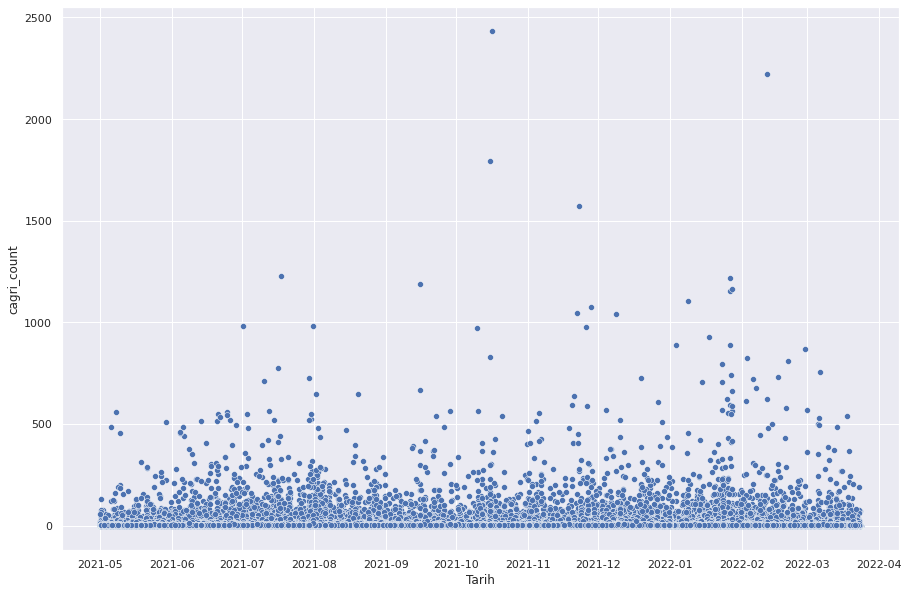

In [94]:
#Target values distribution 
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x='Tarih',y='cagri_count',data=train[train.Tarih<'2022-03-24 07:00:00'])

In [95]:
#The train data were clustered according to some continuous and categorical featurs, and the obtained clusters were matched to the test data..This process may be provide some generalization 
le=LabelEncoder()
cols=['toplam_kentsel_og','toplam_kentsel_ag','il_ilce','kentsel_ag']
train_dum=train.loc[:,cols]
train_dum.loc[:,[i for i in train_dum.columns if train_dum[i].dtype==object]]=train_dum[[i for i in train_dum.columns if train_dum[i].dtype==object]].apply(lambda x: le.fit_transform(x))
test_dum=test.loc[:,cols]
test_dum.loc[:,[i for i in test_dum.columns if test_dum[i].dtype==object]]=test_dum[[i for i in test_dum.columns if test_dum[i].dtype==object]].apply(lambda x: le.fit_transform(x))
dic={}
for i in range(10,20,10):
    Kmean = KMeans(n_clusters=i)
    labels=Kmean.fit_predict(train_dum)
    test_labels=Kmean.predict(test_dum)
    train['grup_10']=labels.astype(object)
    test['grup_10']=test_labels.astype(object)

# Merging Train and Test data

In [96]:
data=pd.concat([train,test])
col = data.pop('Tarih')
data.insert(1,'Tarih',col)
data.reset_index(drop=True,inplace=True)
data['year']=data.Tarih.dt.year.astype(object)
data['month']=data.Tarih.dt.month.astype(object)
data['dayofmonth']=data.Tarih.dt.day.astype(object)
data['time']=data.Tarih.dt.hour.astype(object)
data['il_ilce']=data.il+'_'+data.ilce
data.drop(['il','ilce'],axis=1,inplace=True)
data['time_label']=data.Tarih.map(lambda x : 'prime_time' if (x.hour>17 & x.hour<22) else 'low_time')
data['week']=np.where(data.Tarih.dt.weekday>5,'weekend','midweek')
data.nufus_label=data.nufus_label.astype(object)

<AxesSubplot:>

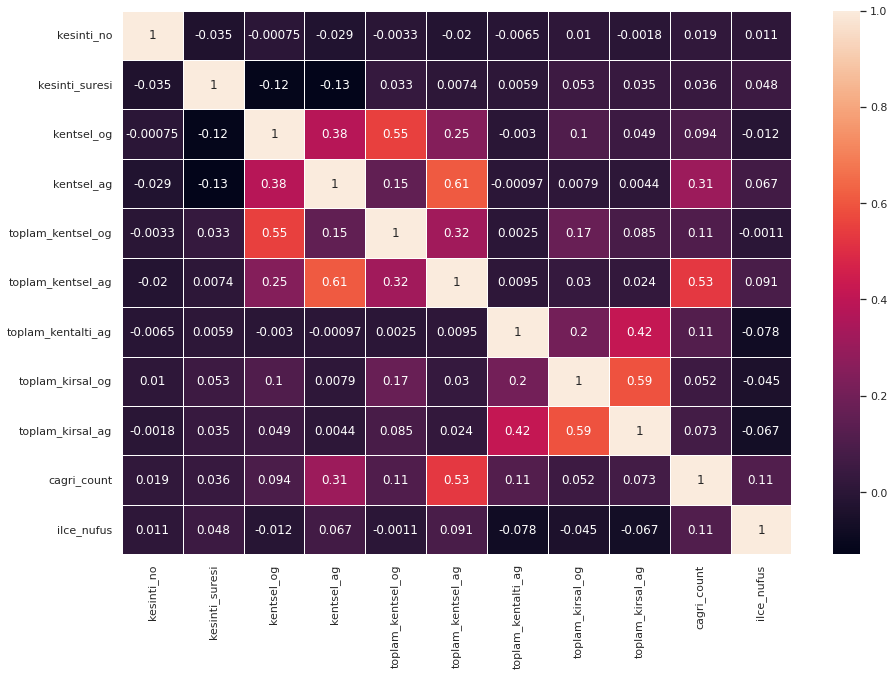

In [97]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data.corr(),annot=True,linewidths=.5)

In [98]:
#unique categorical variables and their labels
for obj_col in obj_cols:
    print(obj_col)
    print("----------")
    print(data[obj_col].unique())
    print("\n----------\n")

sebeke_unsuru
----------
['abone tesisi' 'dm' 'ag fideri' 'kok' 'og fideri' 'tm fideri'
 'saha dagitim kutusu (sdk)' 'dagitim transformatoru']

----------

kesinti_nedenine_iliskin_aciklama
----------
['ag havai bransman arizasi' 'ag bransman yeralti kablo arizasi'
 'og fider acmasi' 'ag pano kol sigorta atigi'
 'ag box / sdk abone cikis sigorta atigi' 'ag atlama kopugu'
 'ag yuk ayirici arizasi' 'og izolator arizasi' 'manevra'
 'og sigorta atmasi' 'ag tel kopugu' 'og trafo arizasi'
 'ag hatta agac kesimi' 'ag sehim bozuklugu' 'ag klemens arizasi'
 'og hatta agac kesimi' 'ag box / sdk giris sigorta atigi'
 'ag termik acmasi' 'ucuncu sahislarin vermis oldugu hasarlar'
 'agac kesimi' 'og kademe ayari' 'ag direkten kesme acma'
 'og atlama arizasi' 'og ayirici arizasi' 'ag kademe ayari' 'yuk aktarimi'
 'ag yeralti kablo arizasi' 'ag direk kirilmasi' 'ag notr iletken kopmasi'
 'og yeralti kablo arizasi' 'ag box arizasi'
 'ag box / sdk abone cikis faz sigorta atigi' 'ag izolator arizasi'
 'f

In [99]:
# Desciptions of Merged datas  
obj_cols=[col for  col in data.columns if data[col].dtype==object]
time_cols=['Tarih','baslama_tarihi_ve_zamani','sona_erme_tarihi_ve_zamani']
num_cols=[col for col in data.columns if data[col].dtype in ['float','int']]
display(data[obj_cols].describe())
display(data.describe())

,sebeke_unsuru,kesinti_nedenine_iliskin_aciklama,kaynaga_gore,sureye_gore,sebebe_gore,il_ilce,nufus_label,grup_10,year,month,dayofmonth,time,time_label,week
count,73036,73036,73036,73036,73036,73036,73036,73036,73036,73036,73036,73036,73036,73036
unique,8,64,3,2,4,47,9,10,2,11,31,24,2,2
top,ag fideri,og fider acmasi,dagitim-ag,uzun,sebeke isletmecisi,izmir_cesme,0-50,0,2021,7,18,9,prime_time,midweek
freq,19034,18385,44980,70546,71241,3489,17748,64181,44683,14716,2823,5192,61693,63632


,kesinti_no,kesinti_suresi,kentsel_og,kentsel_ag,toplam_kentsel_og,toplam_kentsel_ag,toplam_kentalti_ag,toplam_kirsal_og,toplam_kirsal_ag,cagri_count,ilce_nufus
count,7.303600e+04,73036.000000,73036.000000,73036.000000,73036.000000,73036.000000,73036.000000,73036.000000,73036.000000,56285.000000,73036.000000
mean,2.107105e+06,2.363132,10.176926,470.525837,10.135177,411.740472,55.318728,2.270810,59.714724,13.002043,162735.198847
std,1.903445e+05,2.784738,42.190589,1947.567697,68.989319,2035.742777,568.173883,22.513473,507.789038,43.092221,132374.377619
min,1.805939e+06,0.000278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11927.000000
25%,1.898335e+06,0.837500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,52507.000000
50%,2.157428e+06,1.657639,0.000000,12.000000,0.000000,22.405277,0.000000,0.000000,0.000000,4.000000,112049.000000
75%,2.260706e+06,3.051944,1.000000,160.000000,0.366667,217.854583,0.000000,0.000000,0.000000,10.000000,201476.000000
max,2.366166e+06,289.323333,1984.000000,70961.000000,6374.702221,216061.920796,56916.000000,2090.577778,57794.540554,2431.000000,517963.000000


In [100]:
time_cols

['Tarih', 'baslama_tarihi_ve_zamani', 'sona_erme_tarihi_ve_zamani']

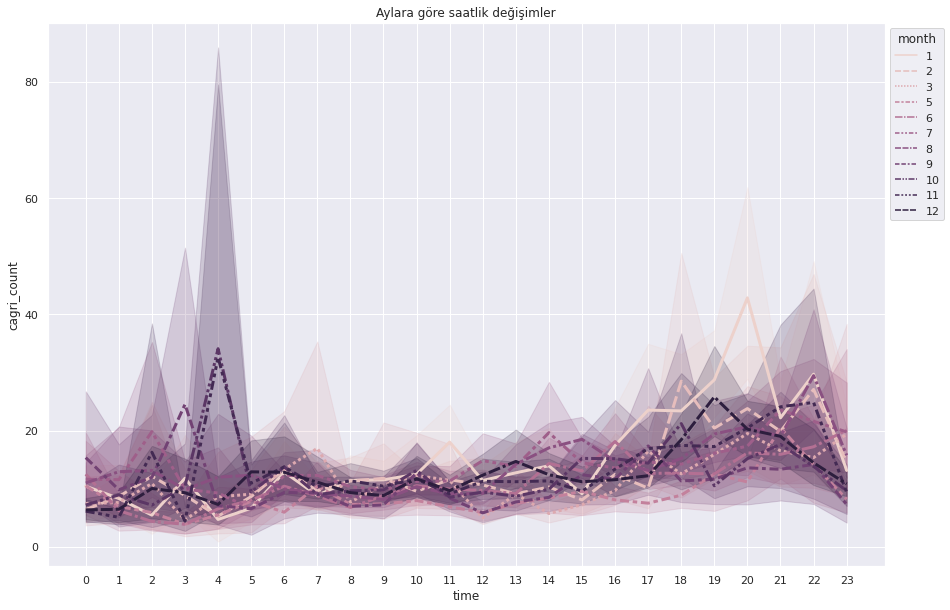

In [101]:
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=data['time'],y=data.cagri_count,hue=data.month,legend=all,linewidth=3,style=data.month)
ax.set_title('Aylara göre saatlik değişimler')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0,24));

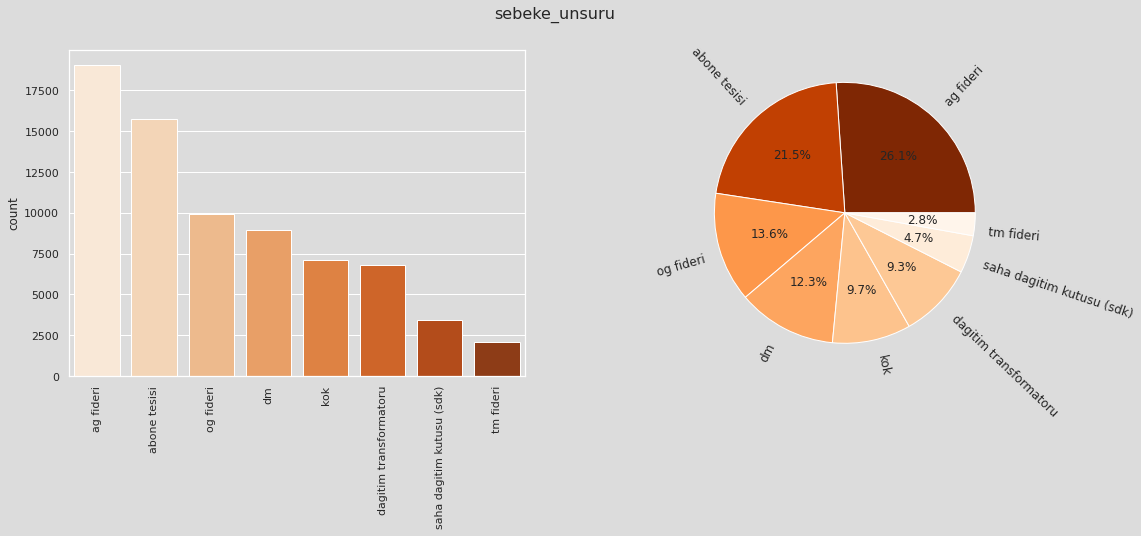

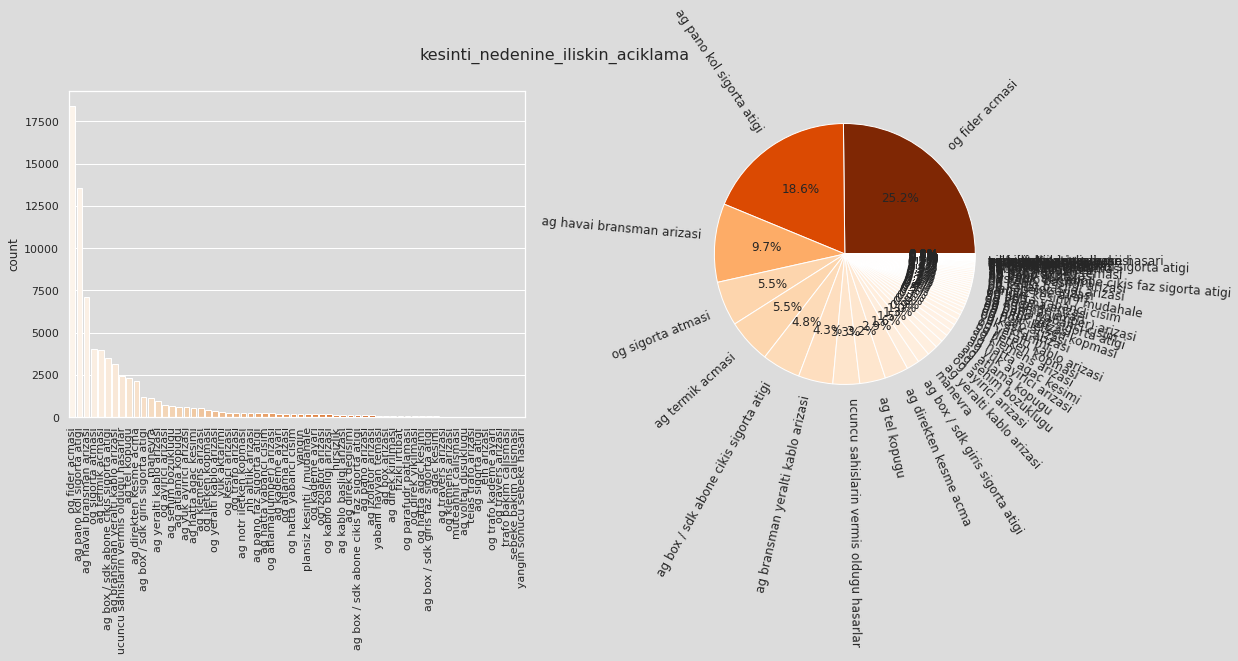

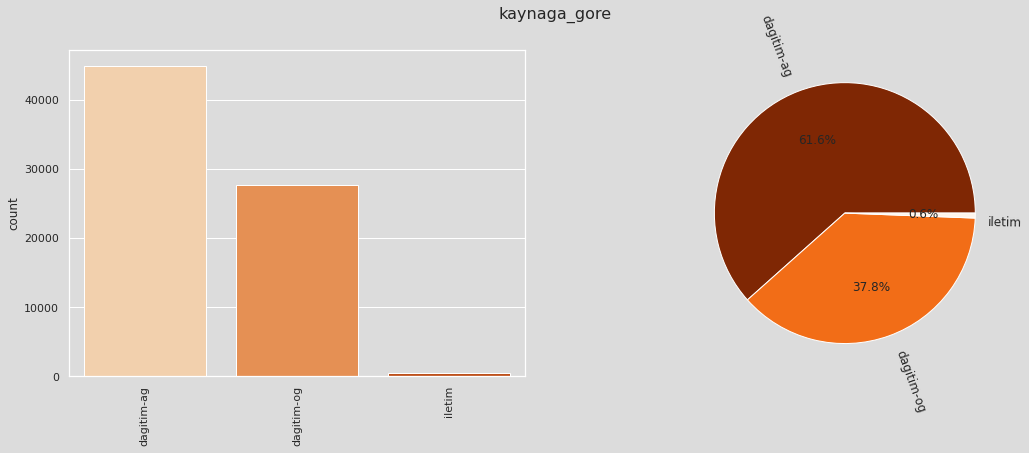

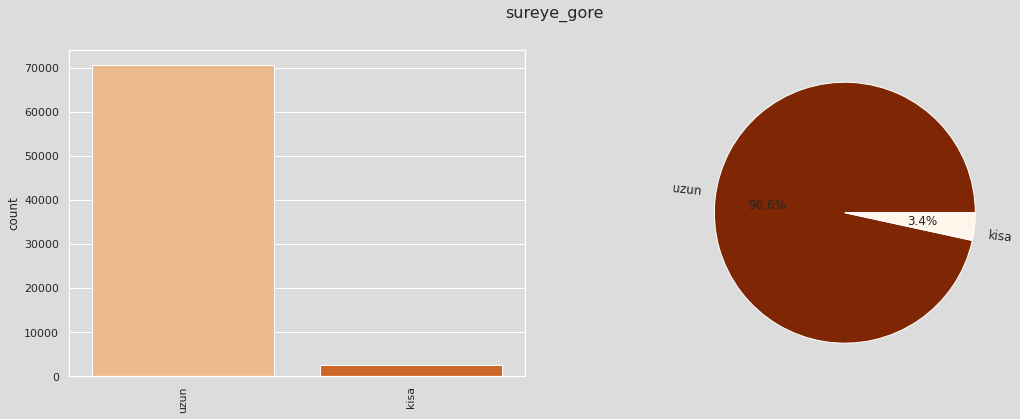

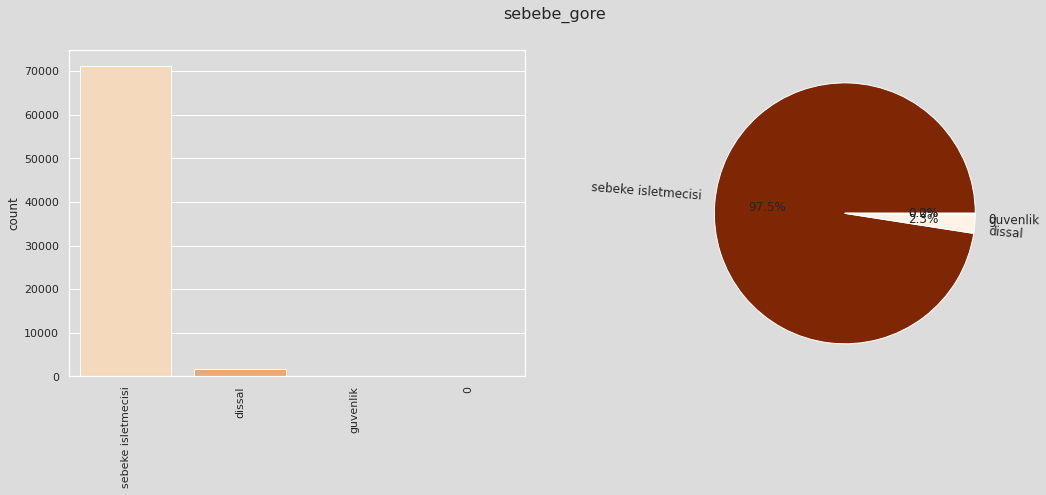

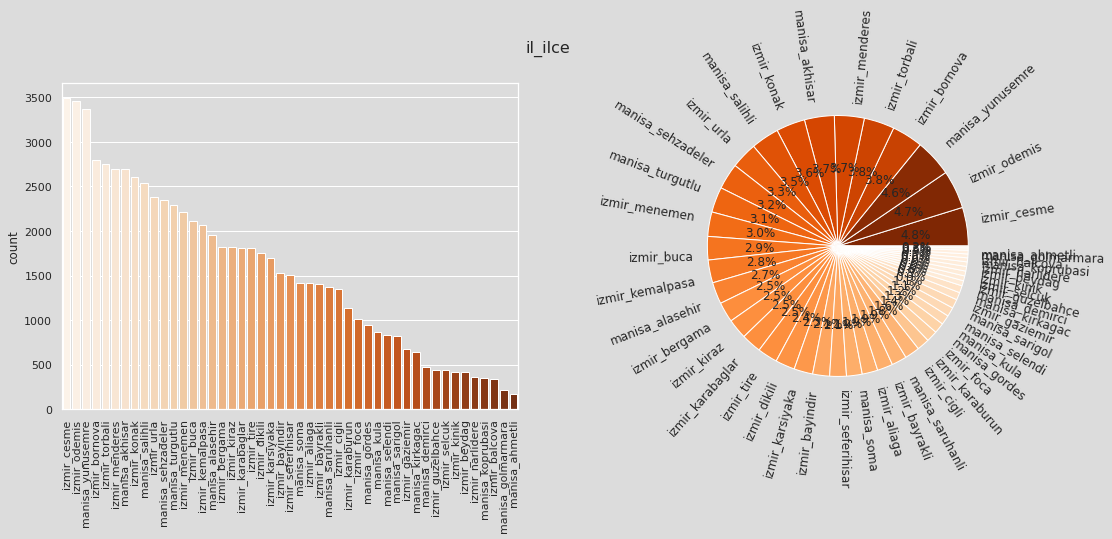

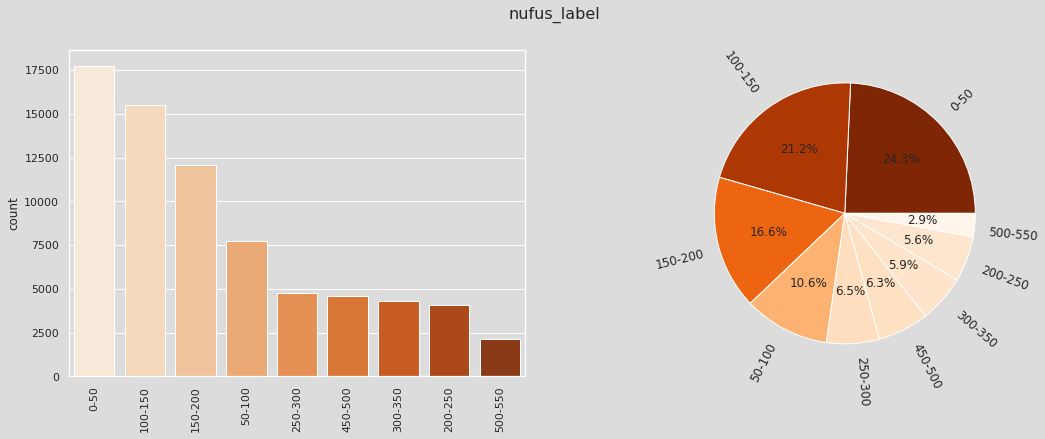

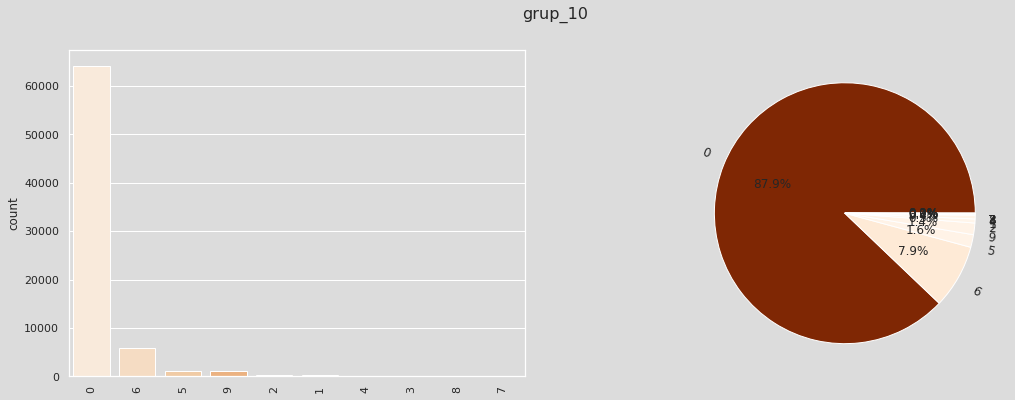

In [104]:
cols=['sebeke_unsuru',
 'kesinti_nedenine_iliskin_aciklama',
 'kaynaga_gore',
 'sureye_gore',
 'sebebe_gore',
 'il_ilce',
 'nufus_label',
 'grup_10']
for col in cols:
    cat_analyser(data, col)

# Some Feature engineering process

In [105]:
dum_label=data.kesinti_nedenine_iliskin_aciklama.value_counts()[data.kesinti_nedenine_iliskin_aciklama.value_counts()<400].index
data.loc[data.kesinti_nedenine_iliskin_aciklama.isin(dum_label),'kesinti_nedenine_iliskin_aciklama']='unknown'

dum_label=data.grup_10.value_counts()[data.grup_10.value_counts()<200].index
data.loc[data.grup_10.isin(dum_label),'grup_10']=10

data.kesinti_suresi=data.kesinti_suresi*60
dum=data[data.cagri_count.notnull()].groupby(['sebebe_gore','il_ilce'])[['kesinti_suresi','cagri_count']].mean().reset_index()
dum['s_g_c']=dum.kesinti_suresi/dum.cagri_count
dum.replace([np.inf, -np.inf], 0, inplace=True)
data=data.merge(dum[['sebebe_gore','il_ilce','s_g_c']],how='left',on=['sebebe_gore','il_ilce'])

dum=data[data.cagri_count.notnull()].groupby(['kaynaga_gore','il_ilce'])[['kesinti_suresi','cagri_count']].mean().reset_index()
dum['k_g_c']=dum.kesinti_suresi/dum.cagri_count
dum.replace([np.inf, -np.inf], 0, inplace=True)
data=data.merge(dum[['kaynaga_gore','il_ilce','k_g_c']],how='left',on=['kaynaga_gore','il_ilce'])

In [106]:
cm = sns.light_palette("red", as_cmap=True)
pd.DataFrame({"NaN Count": data.isna().sum(),
              "NaN Ratio": data.isna().sum()/len(data)}).sort_values(by="NaN Count",
                                                                 ascending=False).style.background_gradient(cmap=cm)

,NaN Count,NaN Ratio
cagri_count,16751,0.229353
k_c,6,0.000082
k_c_2,1,0.000014
Tarih,0,0.000000
week,0,0.000000
time_label,0,0.000000
time,0,0.000000
dayofmonth,0,0.000000
month,0,0.000000
year,0,0.000000


In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73036 entries, 0 to 73035
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   kesinti_no                         73036 non-null  int64         
 1   Tarih                              73036 non-null  datetime64[ns]
 2   sebeke_unsuru                      73036 non-null  object        
 3   kesinti_nedenine_iliskin_aciklama  73036 non-null  object        
 4   kaynaga_gore                       73036 non-null  object        
 5   sureye_gore                        73036 non-null  object        
 6   sebebe_gore                        73036 non-null  object        
 7   baslama_tarihi_ve_zamani           73036 non-null  datetime64[ns]
 8   sona_erme_tarihi_ve_zamani         73036 non-null  datetime64[ns]
 9   kesinti_suresi                     73036 non-null  float64       
 10  kentsel_og                        

# CATBOOST MODEL

* Setting the data to be inserted into the model. There are some features eliminated here.

In [108]:
data2=data.drop([
'kesinti_no', 
'Tarih', 
#'sebeke_unsuru',
#'kesinti_nedenine_iliskin_aciklama', 
#'kaynaga_gore',
#'sureye_gore',
#'sebebe_gore',
# 'il_ilce',
'baslama_tarihi_ve_zamani',
'sona_erme_tarihi_ve_zamani',
#'year', 
#'month',
#'grup_10',
#'dayofmonth',
#'time', 
#'time_label',
#'week'
],axis=1)
cat_features=[col for col in data2.columns if data2[col].dtype==object]
data2.loc[:,[i for i in data2.columns if data2[i].dtype==object]]=data2.loc[:,[i for i in data2.columns if data2[i].dtype==object]].apply(lambda x: le.fit_transform(x))
data_dum=data2.copy()
data_train=data_dum[data_dum.cagri_count.notnull()][1:]
train_target=data_train.cagri_count
data_train.drop(['cagri_count'],axis=1,inplace=True)
data_test=data_dum[data_dum.cagri_count.isnull()]
data_test.drop(['cagri_count'],axis=1,inplace=True)
print('data_dum shape: {}'.format(data_dum.shape))
print('data_train shape: {}'.format(data_train.shape))
print('data_test shape: {}'.format(data_test.shape))

data_dum shape: (73036, 26)
data_train shape: (56284, 25)
data_test shape: (16751, 25)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [111]:
from catboost import CatBoostRegressor
TUNE = True
KF=KFold(n_splits=3, random_state=None, shuffle=True)

def objective(trial,data=data_train,target=train_target):   

    catboost_params = {"subsample": trial.suggest_float("subsample", 0.5, 0.99),
                        'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                        "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
                        "max_depth": trial.suggest_int("max_depth", 4, 10, step=1),
                        "n_estimators": 1000,
                        'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1)}
#     ,
#                         'task_type':"GPU",
#                         'devices':'0:1'}

    tscv_splits = list(KF.split(data,target))  
    rms_errs = []
    
    for split_train, split_val in tscv_splits:
        train_x, train_y = data.iloc[split_train], target.iloc[split_train]
        test_x, test_y = data.iloc[split_val], target.iloc[split_val]
        
        mcat = CatBoostRegressor(**catboost_params)
        mcat.fit(train_x, train_y,
                use_best_model = True,
                early_stopping_rounds = 50,
                 verbose=0,
                  eval_set=(test_x, test_y),
                 cat_features=cat_features
                )
        preds = mcat.predict(test_x)
        rms = mean_squared_error(test_y, preds, squared=False)
        rms_errs.append(rms)
        
    return np.mean(rms_errs)


if TUNE:
    study = optuna.create_study(direction = 'minimize')
    study.optimize(objective, n_trials = 80)
    print('Best value:', study.best_value)

[I 2022-09-16 19:25:44,214] A new study created in memory with name: no-name-abfe38d3-4324-41ae-8367-3b0ab473e693
[I 2022-09-16 19:30:31,040] Trial 0 finished with value: 31.948632384883805 and parameters: {'subsample': 0.9481804566023574, 'od_wait': 38, 'colsample_bylevel': 0.8039135824399252, 'random_strength': 8, 'l2_leaf_reg': 12.193632358818252, 'max_depth': 7, 'learning_rate': 0.019397469359788914}. Best is trial 0 with value: 31.948632384883805.


KeyboardInterrupt: 

* Best paramters obtained from optuna tuned 
>cat_best_params={
 'subsample': 0.9617328247354884, 'od_wait': 16, 'colsample_bylevel': 0.6547746313185058, 'random_strength': 6, 'l2_leaf_reg': 1.5189220321913304, 'max_depth': 8, 'learning_rate': 0.08784068449502132
    ,"n_estimators": 1000} 

In [112]:
cat_best_params={
'subsample': 0.9617328247354884, 'od_wait': 16, 'colsample_bylevel': 0.6547746313185058, 'random_strength': 6, 'l2_leaf_reg': 1.5189220321913304, 'max_depth': 8, 'learning_rate': 0.08784068449502132
    ,"n_estimators": 1000}
KF=KFold(n_splits=3, random_state=None, shuffle=True)
def get_cv_result(model):

    cv_result = cross_val_score(model, data_train,train_target,
                                cv=KF, scoring="neg_root_mean_squared_error",
                                verbose=2)
    print(-cv_result)
    print("RMSE: %0.2f (+/- %0.2f)" % (-cv_result.mean(), cv_result.std()))
    return model
# ------------------------------------------------------
model = CatBoostRegressor(**cat_best_params,verbose=0)
_ = get_cv_result(model)

all_models = []
for i in [234,42]:
    cat_best_params["random_state"] = i
    model =  CatBoostRegressor(**cat_best_params)
    model = model.fit(data_train,train_target,verbose=0)
    all_models.append(model)

cat_preds = [model.predict(data_test) for model in all_models]
cat_mean_preds = np.mean(cat_preds, axis=0)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  18.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV] END .................................................... total time=  20.0s
[CV] END .................................................... total time=  20.0s
[31.8737707  26.34905743 35.05399251]
RMSE: 31.09 (+/- 3.60)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.8s finished


# Ploting Predicted values

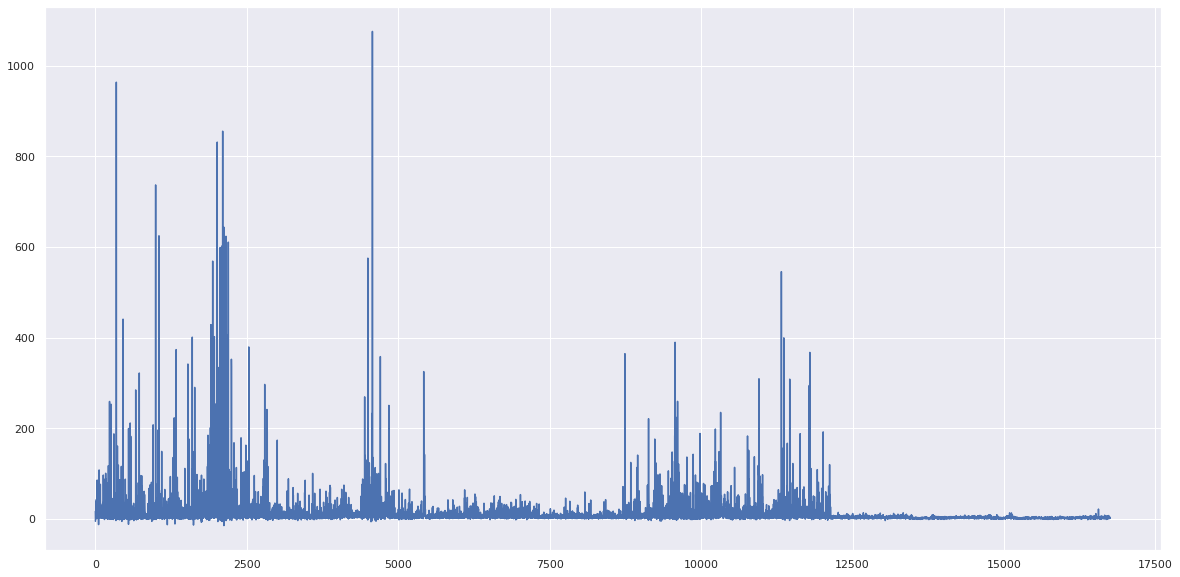

In [118]:
plt.figure(figsize=(20,10))
plt.plot(cat_mean_preds)

# Feature importances 

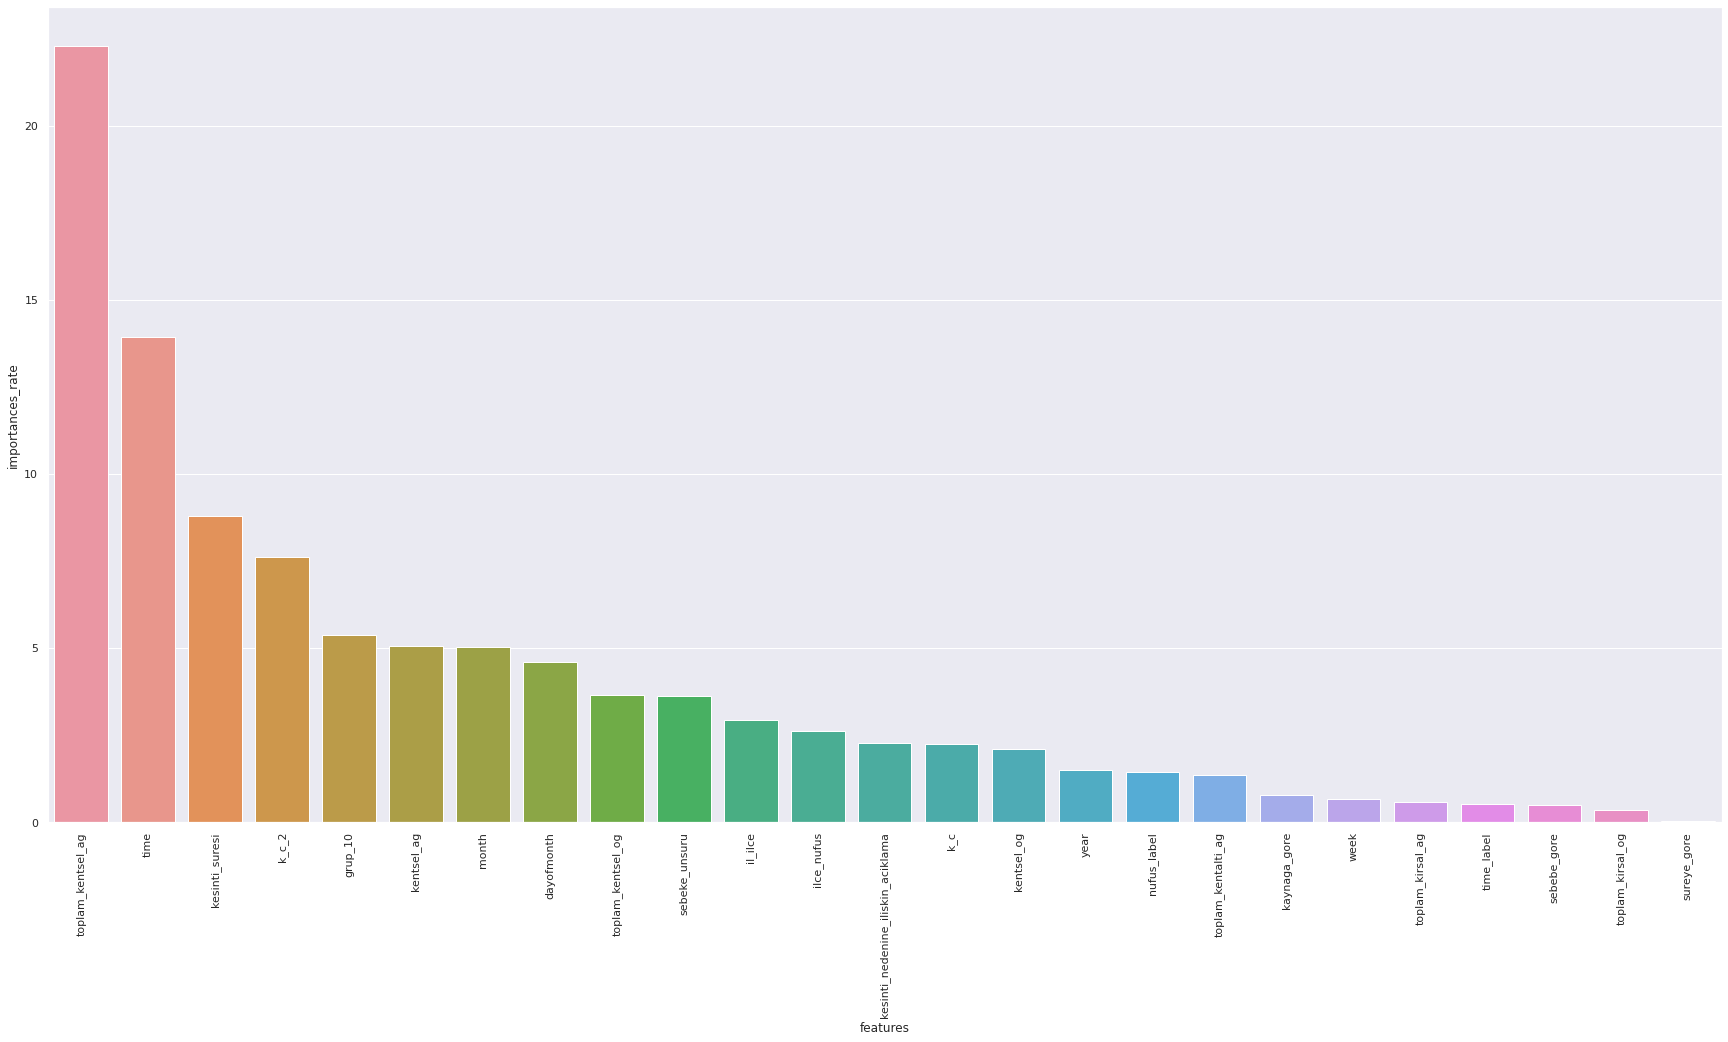

In [115]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':data_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
dum.features=dum.features.map(lambda x:  '_'.join(x) if type(x)==tuple else x)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);
